In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pgmpy.base import DAG
from collections import defaultdict, Counter
from typing import Optional, Any, List, Dict, Tuple, Set
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, BIC, K2, BDeu, ExpertKnowledge, GES

from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete.CPD import TabularCPD
import networkx as nx
import json
from copy import deepcopy
# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


In [180]:
client1_data = pd.read_csv("../fc-fedbaynet/data/client1/client.csv")
client2_data = pd.read_csv("../fc-fedbaynet/data/client2/client.csv")
client3_data = pd.read_csv("../fc-fedbaynet/data/client3/client.csv")
dataset_sizes = [client1_data.shape[0], client2_data.shape[0], client3_data.shape[0]]

In [181]:
with open("../fc-fedbaynet/data/client1/expert_knowledge.json") as f:
    expknowledge = json.load(f)

with open("../fc-fedbaynet/data/client2/expert_knowledge.json") as f:
    expknowledge = json.load(f)

with open("../fc-fedbaynet/data/client3/expert_knowledge.json") as f:
    expknowledge = json.load(f)

blacklist1 = [tuple(edge) for edge in expknowledge["blacklist"]]
whitelist1 = [tuple(edge) for edge in expknowledge["whitelist"]]
blacklist2 = [tuple(edge) for edge in expknowledge["blacklist"]]
whitelist2 = [tuple(edge) for edge in expknowledge["whitelist"]]
blacklist3 = [tuple(edge) for edge in expknowledge["blacklist"]]
whitelist3 = [tuple(edge) for edge in expknowledge["whitelist"]]

whitelists = [whitelist1, whitelist2, whitelist3]
blacklists = [blacklist1, blacklist2, blacklist3]

In [182]:
def visualize_network(structure: Any = None,
                      target_node: str = 'class',
                      target_color: str = '#9f0000',
                      node_color: str = '#22666F',
                      target_size: int = 1200,
                      node_size: int = 800,
                      seed: int = 23,
                      figsize: tuple = (10, 8),
                      save_path: Optional[str] = None,
                      title_prefix: str = "Bayesian Network") -> None:
    graph = nx.Graph()
    if structure is not None and len(structure.edges()) > 0:
        graph.add_edges_from(structure.edges())
    
    if len(graph.nodes()) == 0:
        print("No nodes available for visualization.")
        return 
    
    _, ax = plt.subplots(figsize=figsize)
    
    pos = nx.spring_layout(graph, seed=seed)

    node_colors = [target_color if node == target_node else node_color
                for node in graph.nodes()]
    node_sizes = [target_size if node == target_node else node_size
                for node in graph.nodes()]

    nx.draw(
        graph,
        pos,
        with_labels=False,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',
        alpha=0.8,
        ax=ax 
    )

    nx.draw_networkx_labels(
        graph,
        pos,
        labels={node: node for node in graph.nodes()},
        font_color='black',
        font_weight='bold',
        ax=ax  
    )

    title = f"{title_prefix} - {len(graph.nodes())} nodes, {len(graph.edges())} edges"
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Network visualization saved to: {save_path}")

    plt.show()

In [183]:
def create_initial_client_model(dataset):
    hc = HillClimbSearch(dataset)
    structure = hc.estimate(scoring_method='bic-d')
    model = DiscreteBayesianNetwork(structure.edges())
    estimator = BayesianEstimator(model, dataset)
    for node in model.nodes():
        cpd = estimator.estimate_cpd(node)
        model.add_cpds(cpd)
    
    return model, structure

In [184]:
def create_constrained_client_model(dataset, blacklist, whitelist):
    hc = HillClimbSearch(dataset)
    expknowledge = ExpertKnowledge(forbidden_edges=blacklist, required_edges=whitelist)
    structure = hc.estimate(scoring_method='bic-d', expert_knowledge=expknowledge)
    model = DiscreteBayesianNetwork(structure.edges())
    estimator = BayesianEstimator(model, dataset)
    for node in model.nodes():
        cpd = estimator.estimate_cpd(node)
        model.add_cpds(cpd)
    
    return model, structure

In [185]:
def compute_local_cpts_from_structure_and_data(structure, data):

    model = DiscreteBayesianNetwork(structure)
    
    # 2. Fit the model using MLE
    model = model.fit(data, estimator=MaximumLikelihoodEstimator)
    
    # 3. Extract learned CPDs
    cpts_list = []
    for cpt in model.get_cpds():
        cpt_dict = {
            "variable": cpt.variable,
            "variable_card": cpt.variable_card,
            "values": cpt.values.tolist(),  # Convert numpy array to list
            "evidence": cpt.get_evidence(),
            "evidence_card": cpt.cardinality[1:],
            "cardinality": cpt.cardinality.tolist()
        }
        cpts_list.append(cpt_dict)

    return cpts_list


In [186]:
def majority_voted_network(whitelists: List[List[List[str]]],
        blacklists: List[List[List[str]]],
        local_cpts_scores: List[float]
    ) -> Set[Tuple[str, str]]:
        
        all_edges: Set[Tuple[str, str]] = set()

        def add_valid_edges(edge_list):
            for edge in edge_list:
                if isinstance(edge, (list, tuple)) and len(edge) == 2:
                    u, v = edge
                    if isinstance(u, str) and isinstance(v, str):
                        all_edges.add((u, v))

        for wl in whitelists:
            add_valid_edges(wl)
        for bl in blacklists:
            add_valid_edges(bl)

        wl_votes: Dict[Tuple[str, str], Set[int]] = {edge: set() for edge in all_edges}
        bl_votes: Dict[Tuple[str, str], Set[int]] = {edge: set() for edge in all_edges}

        for client_idx, wl in enumerate(whitelists):
            for edge in wl:
                if tuple(edge) in wl_votes:
                    wl_votes[tuple(edge)].add(client_idx)

        for client_idx, bl in enumerate(blacklists):
            for edge in bl:
                if tuple(edge) in bl_votes:
                    bl_votes[tuple(edge)].add(client_idx)

        final_edges: Set[Tuple[str, str]] = set()

        for edge in all_edges:
            wl_count = len(wl_votes[edge])
            bl_count = len(bl_votes[edge])

            if wl_count > bl_count:
                final_edges.add(edge)
            elif bl_count > wl_count:
                continue 
            else:
                wl_score = sum(local_cpts_scores[i] for i in wl_votes[edge])
                bl_score = sum(local_cpts_scores[i] for i in bl_votes[edge])

                if wl_score >= bl_score:
                    final_edges.add(edge)

        return final_edges

def cpt_confidence_score(local_cpts: List[Dict]) -> float:
    score = 0.0
    for cpt in local_cpts:
        values = np.array(cpt["values"])
        max_probs = values.max(axis=0)
        score += max_probs.sum()
    return score


import networkx as nx
from typing import List, Dict, Set, Tuple

def create_constrained_global_network(
    whitelists: List[List[List[str]]],
    blacklists: List[List[List[str]]],
    local_cpts: List[List[Dict]]
):
    # Compute confidence scores for each client's CPTs
    local_cpts_scores = [cpt_confidence_score(cpts) for cpts in local_cpts]

    # Get the final set of edges from majority voting
    final_edges = majority_voted_network(
        whitelists,
        blacklists,
        local_cpts_scores
    )

    # Filter and ensure edges are valid (tuples of strings)
    valid_edges = [
        (str(u), str(v))
        for (u, v) in final_edges
        if isinstance(u, str) and isinstance(v, str) and len((u, v)) == 2
    ]

    # Initialize empty model
    model = DiscreteBayesianNetwork()

    if valid_edges:
        # Extract unique nodes from edges
        nodes = set()
        for u, v in valid_edges:
            nodes.add(u)
            nodes.add(v)

        # Add all nodes first
        for node in nodes:
            model.add_node(node)

        # Then add edges
        for edge in valid_edges:
            model.add_edge(*edge)

        # Check for cycles and remove edges that cause cycles
        G = nx.DiGraph()
        G.add_edges_from(valid_edges)

        if not nx.is_directed_acyclic_graph(G):
            edges_to_keep = []
            for edge in valid_edges:
                G_temp = nx.DiGraph(edges_to_keep + [edge])
                if nx.is_directed_acyclic_graph(G_temp):
                    edges_to_keep.append(edge)

            # Rebuild the model with only edges that do not create cycles
            model = DiscreteBayesianNetwork()
            for node in nodes:
                model.add_node(node)
            for edge in edges_to_keep:
                model.add_edge(*edge)
    else:
        # No edges: add all variables from local CPTs as isolated nodes
        for cpts in local_cpts:
            for cpt in cpts:
                if not model.has_node(cpt["variable"]):
                    model.add_node(cpt["variable"])

    return model


In [187]:
def aggregate_cpts(cpt_lists, weights):
    
    if len(cpt_lists) != len(weights):
        raise ValueError("Number of CPT lists must match number of weights")
    
    for i, cpt_list in enumerate(cpt_lists):
        if not isinstance(cpt_list, list):
            raise TypeError(f"CPT list at index {i} is not a list: {type(cpt_list)}")
        for j, cpt in enumerate(cpt_list):
            if not isinstance(cpt, dict):
                raise TypeError(f"CPT at index {j} in list {i} is not a dict: {type(cpt)}")
            required_keys = ['variable', 'variable_card', 'values', 'evidence', 'evidence_card', 'cardinality']
            for key in required_keys:
                if key not in cpt:
                    raise KeyError(f"CPT at index {j} in list {i} missing key: {key}")

    # Extract all unique variables
    all_variables = set()
    for cpt_list in cpt_lists:
        for cpt in cpt_list:
            all_variables.add(cpt['variable'])
    all_variables = sorted(list(all_variables)) 
    
    aggregated_cpts = []
    
    for var in all_variables:
        # Collect CPTs for this variable across all lists
        var_cpts = []
        cpt_weights = []
        for i, cpt_list in enumerate(cpt_lists):
            cpt = next((c for c in cpt_list if c['variable'] == var), None)
            if cpt is not None:
                var_cpts.append(cpt)
                cpt_weights.append(weights[i])
        
        if not var_cpts:
            continue  
        
        # Determine unified evidence structure 
        evidence_sets = [set(cpt['evidence']) for cpt in var_cpts]
        all_evidence = sorted(list(set.union(*evidence_sets)))  
        
        max_evidence_cards = []
        for ev in all_evidence:
            max_card = 1
            for cpt in var_cpts:
                if ev in cpt['evidence']:
                    idx = cpt['evidence'].index(ev)
                    max_card = max(max_card, cpt['evidence_card'][idx])
            max_evidence_cards.append(max_card)
        
        # Pad evidence dimensions
        padded_values = []
        for cpt, weight in zip(var_cpts, cpt_weights):
            curr_shape = [cpt['variable_card']] + list(cpt['evidence_card'])
            curr_evidence = cpt['evidence']
            target_shape = [cpt['variable_card']] + max_evidence_cards
            
            # Convert values to numpy array if it's not already
            values = cpt['values']
            if not isinstance(values, np.ndarray):
                values = np.array(values)
            
            if values.shape != tuple(curr_shape):
                values = np.reshape(values, curr_shape)
            
            if curr_evidence:
                expanded_values = values
                
                # Build mapping from current evidence to target evidence structure
                curr_to_target_map = []
                for i, ev in enumerate(all_evidence):
                    if ev in curr_evidence:
                        curr_idx = curr_evidence.index(ev)
                        curr_to_target_map.append(curr_idx + 1) 
                    else:
                        curr_to_target_map.append(-1) 
                
                new_axes_order = [0]
                singleton_positions = []
                
                for i, (ev, target_pos) in enumerate(zip(all_evidence, curr_to_target_map)):
                    if target_pos != -1:
                        new_axes_order.append(target_pos)
                    else:
                        singleton_positions.append(i + 1)
                
                if len(new_axes_order) > 1:
                    expanded_values = np.transpose(expanded_values, new_axes_order)
                
                for pos in singleton_positions:
                    expanded_values = np.expand_dims(expanded_values, axis=pos)
                
                # Pad evidence dimensions to max cardinalities
                final_values = np.zeros(target_shape, dtype=float)
                slices = [slice(0, cpt['variable_card'])]  
                for i, (ev, max_card) in enumerate(zip(all_evidence, max_evidence_cards)):
                    if ev in curr_evidence:
                        curr_idx = curr_evidence.index(ev)
                        curr_card = cpt['evidence_card'][curr_idx]
                        slices.append(slice(0, curr_card))
                    else:
                        slices.append(slice(0, 1))
                
                final_values[tuple(slices)] = expanded_values
                padded_values.append(final_values * weight)
                
            else:
                expanded_values = values
                for _ in max_evidence_cards:
                    expanded_values = expanded_values[..., np.newaxis]
                
                # Broadcast to target shape
                final_values = np.broadcast_to(expanded_values, target_shape)
                padded_values.append(final_values * weight)
    
        max_var_card = max(cpt['variable_card'] for cpt in var_cpts)
        final_shape = [max_var_card] + max_evidence_cards
        
        final_padded_values = []
        
        for padded_val, weight in zip(padded_values, cpt_weights):
            if padded_val.shape[0] < max_var_card:
                final_padded = np.zeros(final_shape, dtype=float)
                slices = [slice(0, padded_val.shape[0])] + [slice(0, s) for s in padded_val.shape[1:]]
                final_padded[tuple(slices)] = padded_val
                final_padded_values.append(final_padded)
            else:
                final_padded_values.append(padded_val)
        
        total_weight = sum(cpt_weights)
        if total_weight > 0:
            aggregated_values = np.sum([val * weight for val, weight in zip(final_padded_values, cpt_weights)], axis=0) / total_weight
        else:
            aggregated_values = np.sum(final_padded_values, axis=0)
        
        # Normalize to ensure probabilities sum to 1 for each evidence configuration
        values_reshaped = aggregated_values.reshape(max_var_card, -1)
        
        column_sums = values_reshaped.sum(axis=0)
        zero_columns = column_sums == 0
        values_normalized = values_reshaped.copy()
        
        # Normalize non-zero columns
        if np.any(~zero_columns):
            values_normalized[:, ~zero_columns] = values_reshaped[:, ~zero_columns] / column_sums[~zero_columns]
        
        # Set uniform distribution for zero columns
        if np.any(zero_columns):
            values_normalized[:, zero_columns] = 1.0 / max_var_card
        
        # Reshape back to original shape
        final_aggregated_values = values_normalized.reshape(final_shape)
        
        new_cpt = {
            'variable': var,
            'variable_card': max_var_card,
            'values': final_aggregated_values,
            'evidence': all_evidence,
            'evidence_card': np.array(max_evidence_cards, dtype=int),
            'cardinality': np.array([max_var_card] + max_evidence_cards, dtype=int)
        }
        aggregated_cpts.append(new_cpt)
    
    return aggregated_cpts

In [188]:
def build_model_from_cpts(cpts):
    model = DiscreteBayesianNetwork()
    
    variable_cardinality = {}
    for cpt in cpts:
        variable_cardinality[cpt['variable']] = cpt['variable_card']
        for ev, ev_card in zip(cpt['evidence'], cpt['evidence_card']):
            if ev not in variable_cardinality:
                variable_cardinality[ev] = ev_card
    
    model.add_nodes_from(variable_cardinality.keys())
    
    for cpt in cpts:
        child = cpt['variable']
        for parent in cpt['evidence']:
            if not model.has_edge(parent, child):
                try:
                    model.add_edge(parent, child)
                except ValueError as e:
                    if "loop" in str(e).lower():
                        print(f"Skipped edge {parent} -> {child} to avoid cycle")
                    else:
                        raise e
    
    # Marginalize CPD values when parents are dropped
    def marginalize_cpd_values(values_array, original_evidence, original_evidence_card, kept_parents):

        if not kept_parents:
            marginalized = values_array
            for _ in range(len(original_evidence)):
                marginalized = marginalized.sum(axis=1)  
            return marginalized.reshape(-1, 1)
        
        if len(kept_parents) == len(original_evidence) and all(p in original_evidence for p in kept_parents):
            return values_array
    
        kept_indices = []
        for parent in kept_parents:
            if parent in original_evidence:
                kept_indices.append(original_evidence.index(parent))
        
        if not kept_indices:
            marginalized = values_array
            for _ in range(len(original_evidence)):
                marginalized = marginalized.sum(axis=1)
            return marginalized.reshape(-1, 1)
        
        # Marginalize out dropped parents
        all_indices = list(range(len(original_evidence)))
        drop_indices = [i for i in all_indices if i not in kept_indices]
        
        marginalized = values_array
        for drop_idx in sorted(drop_indices, reverse=True):
            marginalized = marginalized.sum(axis=drop_idx + 1)  
        
        if len(kept_indices) > 1:
            expected_order = [original_evidence.index(p) for p in kept_parents if p in original_evidence]
            current_order = sorted(kept_indices)
            if expected_order != current_order:
                print(f"Warning: Parent order changed for some parents")
        
        return marginalized
    
    def normalize_cpd(values):
        if values.ndim == 1:
            values = values.reshape(-1, 1)
        elif values.ndim == 0:
            values = values.reshape(1, 1)
        
        col_sums = values.sum(axis=0, keepdims=True)
    
        col_sums[col_sums == 0] = 1e-12
        normalized = values / col_sums
        
        if normalized.ndim == 1:
            normalized = normalized.reshape(-1, 1)
        
        return normalized
    
    cpds = []
    for cpt in cpts:
        variable = cpt['variable']
        variable_card = variable_cardinality[variable]
        original_evidence = cpt['evidence']
        original_evidence_card = cpt['evidence_card']
        
        parents = list(model.predecessors(variable))  
        
        values_array = np.array(cpt['values'])
        
        marginalized_values = marginalize_cpd_values(
            values_array, original_evidence, original_evidence_card, parents
        )
        
        if marginalized_values.ndim == 1:
            marginalized_values = marginalized_values.reshape(-1, 1)
        elif marginalized_values.ndim == 0:
            marginalized_values = marginalized_values.reshape(1, 1)
        
        normalized_values = normalize_cpd(marginalized_values)
        
        evidence_card = [variable_cardinality[p] for p in parents] if parents else None
        
        if parents:
            expected_cols = np.prod(evidence_card)

            if normalized_values.ndim != 2:
                if normalized_values.ndim == 1:
                    normalized_values = normalized_values.reshape(-1, 1)
                else:
                    normalized_values = normalized_values.reshape(variable_card, -1)
            
            if normalized_values.shape[1] != expected_cols:

                if normalized_values.size == variable_card * expected_cols:
                    normalized_values = normalized_values.reshape(variable_card, expected_cols)
                else:
                    if normalized_values.shape[1] < expected_cols:

                        missing_factor = expected_cols // normalized_values.shape[1]
                        if expected_cols % normalized_values.shape[1] == 0:
                            normalized_values = np.repeat(normalized_values, missing_factor, axis=1)
                        else:
                            uniform_values = np.ones((variable_card, expected_cols)) / variable_card
                            normalized_values = uniform_values
                            print(f"Created uniform distribution for {variable}")
                    else:
                        normalized_values = normalized_values[:, :expected_cols]
                        print(f"Truncated columns for {variable}")
        else:
            if normalized_values.ndim != 2:
                normalized_values = normalized_values.reshape(variable_card, 1)
        
        if normalized_values.ndim != 2:
            raise TypeError(f"After all processing, values for {variable} is still not 2D: shape={normalized_values.shape}, ndim={normalized_values.ndim}")
        
        cpd = TabularCPD(
            variable=variable,
            variable_card=variable_card,
            values=normalized_values,
            evidence=parents if parents else None,
            evidence_card=evidence_card
        )
        
        cpds.append(cpd)
    
    model.add_cpds(*cpds)
    
    if not model.check_model():
        print("Warning: Model validation failed. This might be due to normalization issues.")
        for cpd in model.get_cpds():
            if not np.allclose(cpd.values.sum(axis=0), 1.0, rtol=1e-10):
                print(f"CPD for {cpd.variable} does not sum to 1.0")
    
    return model

In [189]:
def update_network_structure(model, whitelist=None, blacklist=None):
        edges = set(model.edges())
        if blacklist:
            for edge in blacklist:
                edges.discard(edge)
        
        nodes = set(model.nodes())
        
        new_model = DiscreteBayesianNetwork()
        new_model.add_nodes_from(nodes)
        new_model.add_edges_from(edges)
        
        if whitelist:
            for edge in whitelist:
                parent, child = edge
                if parent not in nodes:
                    new_model.add_node(parent)
                    nodes.add(parent)
                if child not in nodes:
                    new_model.add_node(child)
                    nodes.add(child)
                
                try:
                    new_model.add_edge(parent, child)
                except ValueError as e:
                    print(f"Skipped adding edge {edge}: {e}")
        
        return new_model

In [190]:
def aggregate_structures(local_models: List[DiscreteBayesianNetwork],
                         threshold: int = 2) -> DiscreteBayesianNetwork:
    
    edge_counts = Counter()
    all_nodes = set()

    for model in local_models:
        all_nodes.update(model.nodes())
        edge_counts.update(list(model.edges()))

    global_edges = [edge for edge, count in edge_counts.items() if count >= threshold]
    
    G = nx.DiGraph()
    G.add_nodes_from(all_nodes)
    
    edges_to_keep = []
    for u, v in global_edges:
        G_temp = nx.DiGraph(edges_to_keep + [(u, v)])
        if nx.is_directed_acyclic_graph(G_temp):
            edges_to_keep.append((u, v))
            
    global_model_structure = DiscreteBayesianNetwork(edges_to_keep)
    global_model_structure.add_nodes_from(all_nodes) 
    
    print(f"Aggregated structure has {len(global_model_structure.nodes())} nodes and {len(global_model_structure.edges())} edges.")
    
    return global_model_structure

In [222]:
def kl_divergence(p, q):
    # Compute KL divergence between two discrete distributions p and q
    p = np.asarray(p)
    q = np.asarray(q)
    # Add small value to avoid zero division
    p = p + 1e-12
    q = q + 1e-12
    return np.sum(p * np.log(p / q))

def cpds_similarity(cpd1, cpd2):
    """
    Compare two CPDs (assumed tabular) and return a similarity score.
    Lower KL-divergence means more similar.
    """
    values1 = cpd1.get_values().flatten()
    values2 = cpd2.get_values().flatten()
    return -kl_divergence(values1, values2)  # Negative so higher = more similar

def intersect_bn_with_cpds(bn1, bn2, threshold=0.5):
    common_nodes = set(bn1.nodes()).intersection(set(bn2.nodes()))
    edges1 = set(bn1.edges())
    edges2 = set(bn2.edges())
    common_edges = edges1.intersection(edges2)

    # Filter edges by CPD similarity
    filtered_edges = []
    for u, v in common_edges:
        try:
            cpd1 = bn1.get_cpds(v)
            cpd2 = bn2.get_cpds(v)
            sim_score = cpds_similarity(cpd1, cpd2)
            if sim_score >= threshold:  # threshold can be tuned
                filtered_edges.append((u, v))
        except:
            # Missing CPDs? Keep edge or skip based on preference
            filtered_edges.append((u, v))

    bn_intersection = DiscreteBayesianNetwork()
    bn_intersection.add_nodes_from(common_nodes)
    bn_intersection.add_edges_from(filtered_edges)
    return bn_intersection


### Iteration 1

#### CLIENT

In [192]:
client1_base_model, _ = create_constrained_client_model(client1_data, blacklist1, whitelist1)
client2_base_model, _ = create_constrained_client_model(client2_data, blacklist2, whitelist2)
client3_base_model, _ = create_constrained_client_model(client3_data, blacklist3, whitelist3)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) infer

  0%|          | 0/1000000 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) infer

  0%|          | 0/1000000 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) infer

  0%|          | 0/1000000 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}


In [193]:
client1_cpts1 = compute_local_cpts_from_structure_and_data(client1_base_model, client1_data)
client2_cpts1 = compute_local_cpts_from_structure_and_data(client2_base_model, client2_data)
client3_cpts1 = compute_local_cpts_from_structure_and_data(client3_base_model, client3_data)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) infer

In [194]:
clients_cpts_list1 = [client1_cpts1, client2_cpts1, client3_cpts1]

#### COORDINATOR

In [195]:
aggregated_cpts1 = aggregate_cpts(clients_cpts_list1, dataset_sizes)

In [196]:
aggregated_network1 = build_model_from_cpts(aggregated_cpts1)

Skipped edge al -> class to avoid cycle
Skipped edge appet -> pe to avoid cycle
Skipped edge class -> pe to avoid cycle
Skipped edge pc -> pe to avoid cycle
Skipped edge bu -> rbc to avoid cycle
Skipped edge pc -> rbc to avoid cycle


### Iteration 3

#### CLIENT

In [197]:
# client1_network2, _ = create_constrained_client_model(client1_data, blacklist1, whitelist1)
# client2_network2, _ = create_constrained_client_model(client2_data, blacklist2, whitelist2)
# client3_network2, _ = create_constrained_client_model(client3_data, blacklist3, whitelist3)

In [223]:
fused_client1_network2 = intersect_bn_with_cpds(client1_base_model, aggregated_network1)
fused_client2_network2 = intersect_bn_with_cpds(client2_base_model, aggregated_network1)
fused_client3_network2 = intersect_bn_with_cpds(client3_base_model, aggregated_network1)

In [224]:
client1_cpts2 = compute_local_cpts_from_structure_and_data(fused_client1_network2, client1_data)
client2_cpts2 = compute_local_cpts_from_structure_and_data(fused_client2_network2, client2_data)
client3_cpts2 = compute_local_cpts_from_structure_and_data(fused_client3_network2, client3_data)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) infer

In [225]:
clients_cpts_list2 = [client1_cpts2, client2_cpts2, client3_cpts2]

#### COORDINATOR

In [226]:
aggregated_cpts2 = aggregate_cpts(clients_cpts_list2, dataset_sizes)

In [227]:
aggregated_network2 = build_model_from_cpts(aggregated_cpts2)

Created uniform distribution for cad


### Iteration 3

#### CLIENT

In [228]:
# client1_network3, _ = create_constrained_client_model(client1_data, blacklist1, whitelist1)
# client2_network3, _ = create_constrained_client_model(client2_data, blacklist2, whitelist2)
# client3_network3, _ = create_constrained_client_model(client3_data, blacklist3, whitelist3)

In [229]:
fused_client1_network3 = intersect_bn_with_cpds(client1_base_model, aggregated_network2)
fused_client2_network3 = intersect_bn_with_cpds(client2_base_model, aggregated_network2)
fused_client3_network3 = intersect_bn_with_cpds(client3_base_model, aggregated_network2)

In [230]:
client1_cpts3 = compute_local_cpts_from_structure_and_data(fused_client1_network3, client1_data)
client2_cpts3 = compute_local_cpts_from_structure_and_data(fused_client2_network3, client2_data)
client3_cpts3 = compute_local_cpts_from_structure_and_data(fused_client3_network3, client3_data)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) infer

In [231]:
clients_cpts_list3 = [client1_cpts3, client2_cpts3, client3_cpts3]

#### COORDINATOR

In [232]:
aggregated_cpts3 = aggregate_cpts(clients_cpts_list3, dataset_sizes)

In [233]:
aggregated_network3 = build_model_from_cpts(aggregated_cpts3)

Created uniform distribution for cad


### Iteration 4

In [234]:
# client1_network4, _ = create_constrained_client_model(client1_data, blacklist1, whitelist1)
# client2_network4, _ = create_constrained_client_model(client2_data, blacklist2, whitelist2)
# client3_network4, _ = create_constrained_client_model(client3_data, blacklist3, whitelist3)

In [235]:
fused_client1_network4 = intersect_bn_with_cpds(client1_base_model, aggregated_network3)
fused_client2_network4 = intersect_bn_with_cpds(client2_base_model, aggregated_network3)
fused_client3_network4 = intersect_bn_with_cpds(client3_base_model, aggregated_network3)

In [236]:
client1_cpts4 = compute_local_cpts_from_structure_and_data(fused_client1_network4, client1_data)
client2_cpts4 = compute_local_cpts_from_structure_and_data(fused_client2_network4, client2_data)
client3_cpts4 = compute_local_cpts_from_structure_and_data(fused_client3_network4, client3_data)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'bp_diastolic': 'N', 'bp_limit': 'N', 'sg': 'N', 'al': 'N', 'class': 'N', 'rbc': 'N', 'su': 'N', 'pc': 'N', 'pcc': 'N', 'ba': 'N', 'bgr': 'N', 'bu': 'N', 'sod': 'N', 'sc': 'N', 'pot': 'N', 'hemo': 'N', 'pcv': 'N', 'rbcc': 'N', 'wbcc': 'N', 'htn': 'N', 'dm': 'N', 'cad': 'N', 'appet': 'N', 'pe': 'N', 'ane': 'N', 'grf': 'N', 'stage': 'N', 'age': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) infer

In [237]:
clients_cpts_list4 = [client1_cpts4, client2_cpts4, client3_cpts4]

#### COORDINATOR

In [238]:
aggregated_cpts4 = aggregate_cpts(clients_cpts_list4, dataset_sizes)

In [239]:
aggregated_network4 = build_model_from_cpts(aggregated_cpts4)

Created uniform distribution for cad


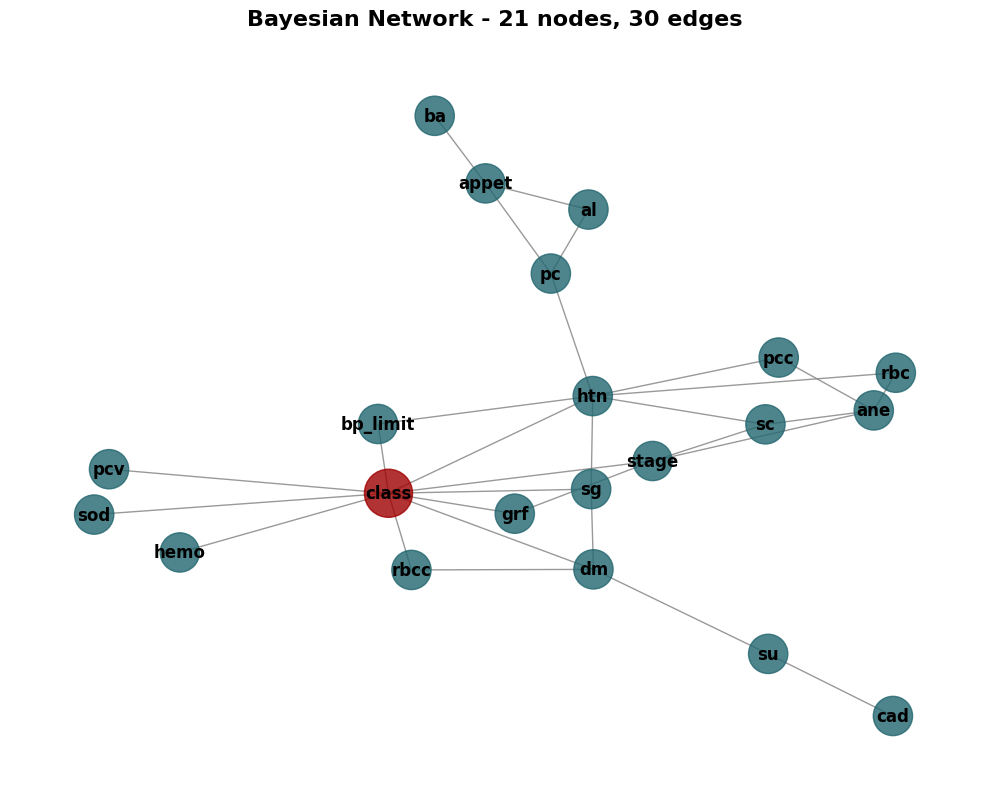

In [243]:
visualize_network(aggregated_network3)

####